In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 61.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.70MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.22MB/s]


In [4]:
class RegularizedNet(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(RegularizedNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.dropout3 = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout3(x)
        x = self.fc4(x)
        return x

In [5]:
def train_model(model, train_loader, test_loader, epochs=20, lr=0.001, l1_lambda=0.001, l2_lambda=0.01):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2_lambda)

    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            l1_norm = sum(p.abs().sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        model.eval()
        test_loss = 0.0
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        train_acc = 100 * correct_train / total_train
        test_acc = 100 * correct_test / total_test

        train_losses.append(running_loss / len(train_loader))
        test_losses.append(test_loss / len(test_loader))
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {running_loss/len(train_loader):.4f}, '
              f'Test Loss: {test_loss/len(test_loader):.4f}, Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%')

    return train_losses, test_losses, train_accuracies, test_accuracies

In [6]:
models = {}
results = {}

model_configs = [
    ('No Regularization', {'dropout_rate': 0.0}, {'lr': 0.001, 'l1_lambda': 0.0, 'l2_lambda': 0.0}),
    ('Dropout Only', {'dropout_rate': 0.5}, {'lr': 0.001, 'l1_lambda': 0.0, 'l2_lambda': 0.0}),
    ('L2 Only', {'dropout_rate': 0.0}, {'lr': 0.001, 'l1_lambda': 0.0, 'l2_lambda': 0.01}),
    ('L1 Only', {'dropout_rate': 0.0}, {'lr': 0.001, 'l1_lambda': 0.001, 'l2_lambda': 0.0}),
    ('All Regularization', {'dropout_rate': 0.5}, {'lr': 0.001, 'l1_lambda': 0.001, 'l2_lambda': 0.01})
]

In [7]:
for name, model_params, train_params in model_configs:
    print(f"\nTraining {name}...")
    model = RegularizedNet(**model_params).to(device)
    models[name] = model
    results[name] = train_model(model, train_loader, test_loader, epochs=15, **train_params)


Training No Regularization...
Epoch [1/15], Train Loss: 0.2470, Test Loss: 0.1165, Train Acc: 92.51%, Test Acc: 96.40%
Epoch [2/15], Train Loss: 0.0945, Test Loss: 0.0922, Train Acc: 97.06%, Test Acc: 97.04%
Epoch [3/15], Train Loss: 0.0632, Test Loss: 0.0814, Train Acc: 98.03%, Test Acc: 97.58%
Epoch [4/15], Train Loss: 0.0470, Test Loss: 0.0720, Train Acc: 98.50%, Test Acc: 98.06%
Epoch [5/15], Train Loss: 0.0386, Test Loss: 0.0642, Train Acc: 98.72%, Test Acc: 98.26%
Epoch [6/15], Train Loss: 0.0318, Test Loss: 0.0924, Train Acc: 98.96%, Test Acc: 97.47%
Epoch [7/15], Train Loss: 0.0254, Test Loss: 0.0730, Train Acc: 99.15%, Test Acc: 98.03%
Epoch [8/15], Train Loss: 0.0239, Test Loss: 0.0931, Train Acc: 99.21%, Test Acc: 97.63%
Epoch [9/15], Train Loss: 0.0240, Test Loss: 0.0736, Train Acc: 99.21%, Test Acc: 98.11%
Epoch [10/15], Train Loss: 0.0188, Test Loss: 0.0663, Train Acc: 99.38%, Test Acc: 98.42%
Epoch [11/15], Train Loss: 0.0176, Test Loss: 0.0852, Train Acc: 99.44%, Test 

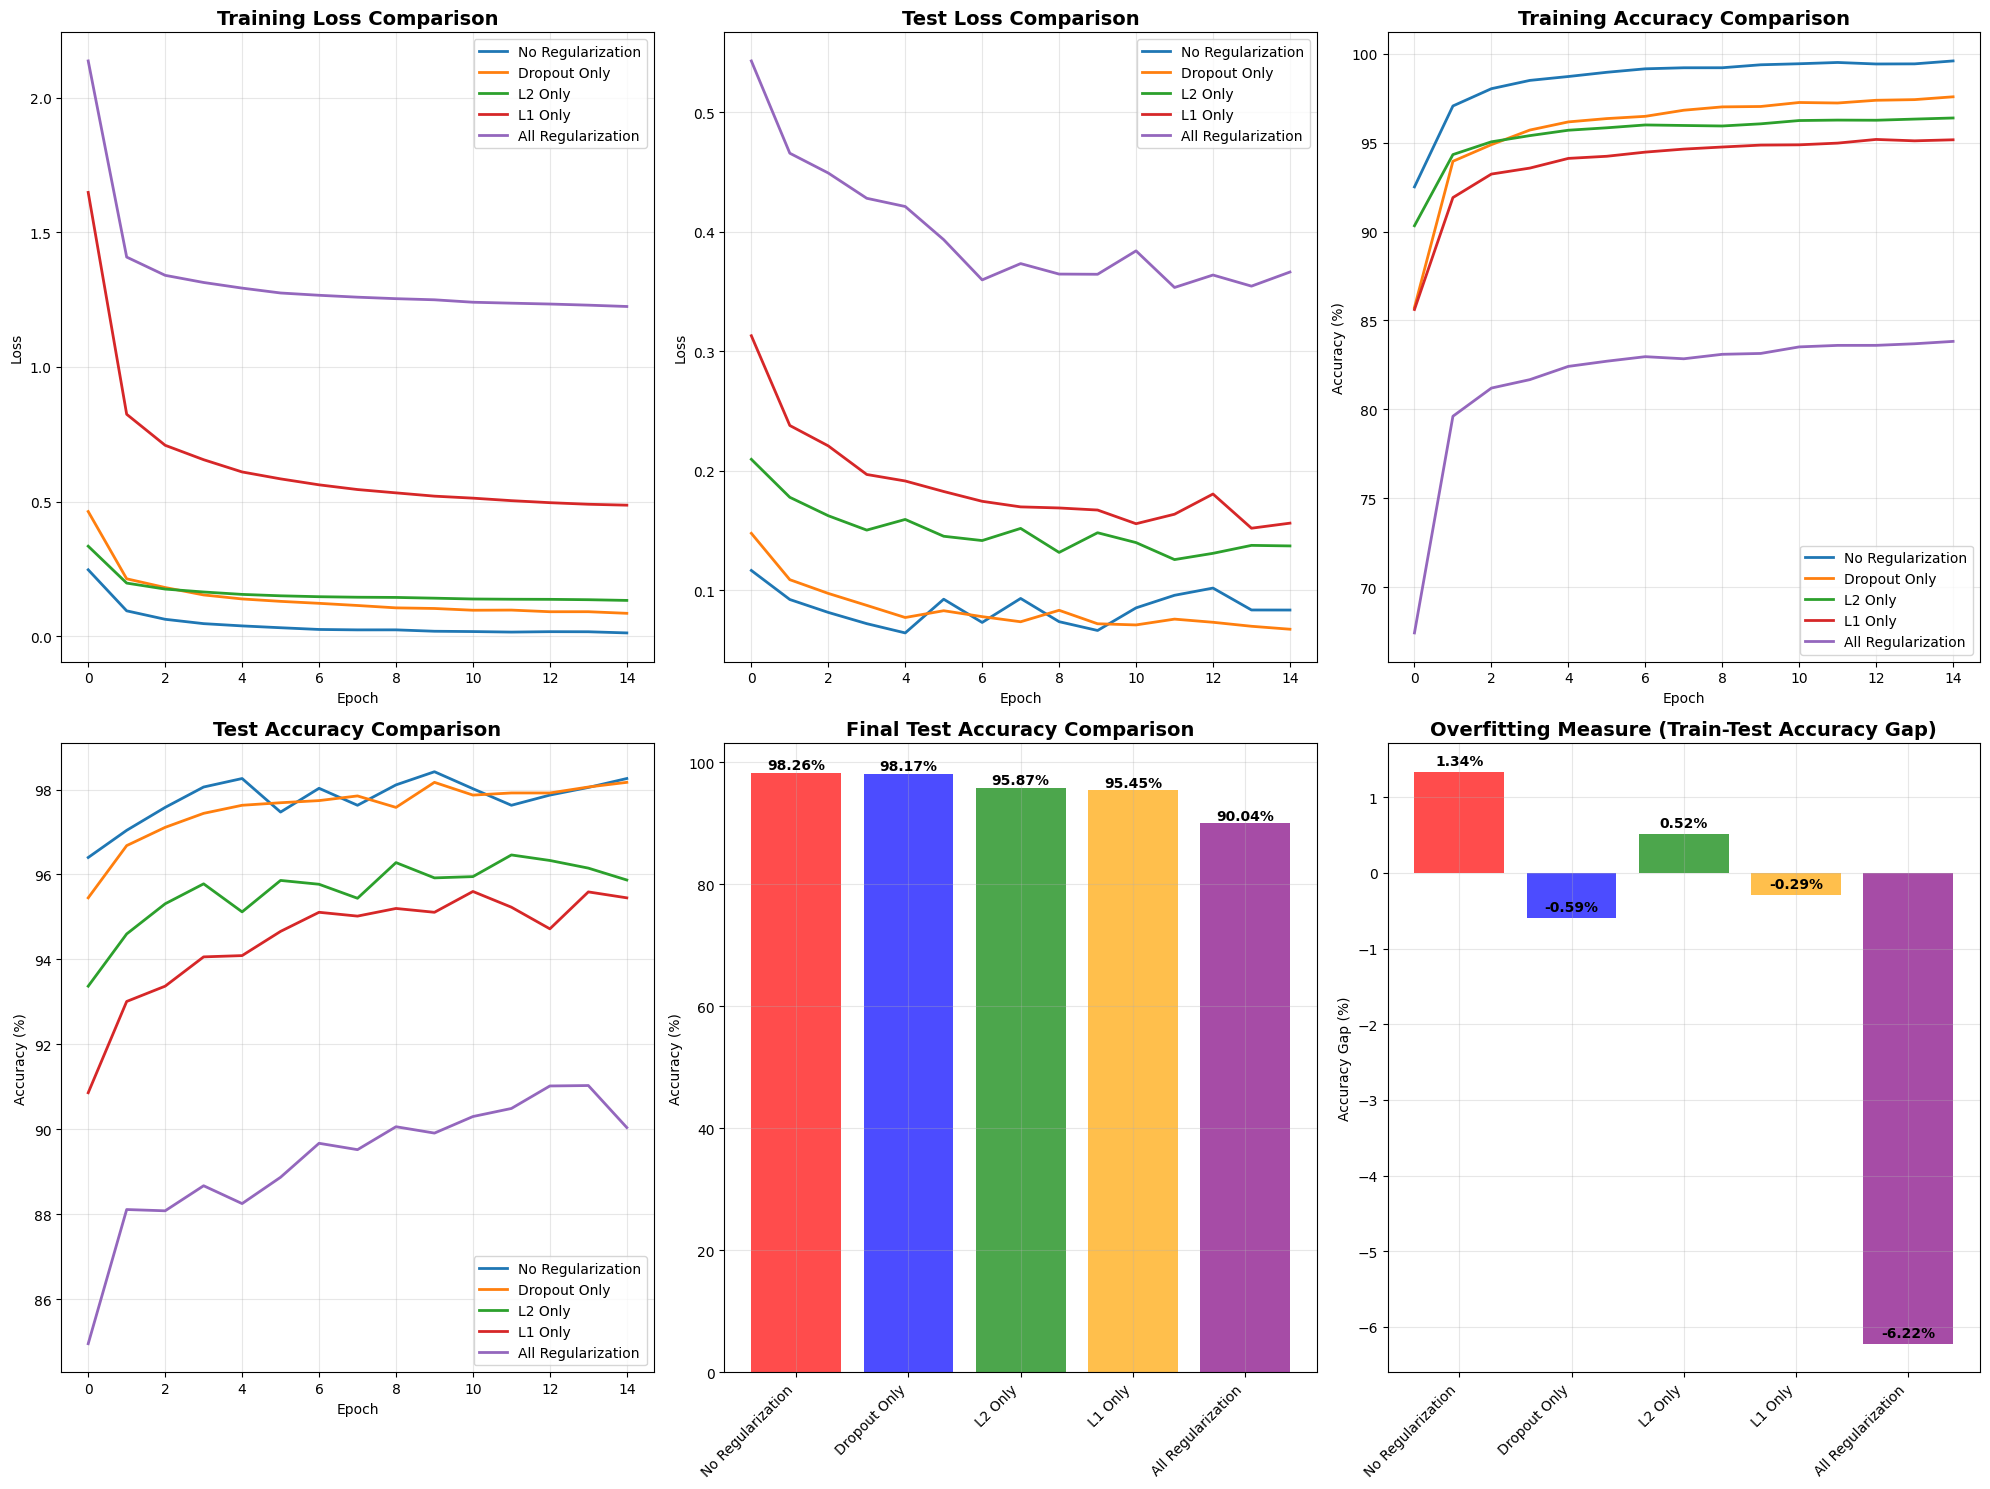

In [8]:
plt.figure(figsize=(20, 15))

plt.subplot(2, 3, 1)
for name in models.keys():
    plt.plot(results[name][0], label=f'{name}', linewidth=2)
plt.title('Training Loss Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 2)
for name in models.keys():
    plt.plot(results[name][1], label=f'{name}', linewidth=2)
plt.title('Test Loss Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 3)
for name in models.keys():
    plt.plot(results[name][2], label=f'{name}', linewidth=2)
plt.title('Training Accuracy Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 4)
for name in models.keys():
    plt.plot(results[name][3], label=f'{name}', linewidth=2)
plt.title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)

final_test_acc = {name: results[name][3][-1] for name in models.keys()}
names = list(final_test_acc.keys())
accuracies = list(final_test_acc.values())

plt.subplot(2, 3, 5)
bars = plt.bar(names, accuracies, color=['red', 'blue', 'green', 'orange', 'purple'], alpha=0.7)
plt.title('Final Test Accuracy Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)

for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{acc:.2f}%', ha='center', va='bottom', fontweight='bold')

overfitting_measure = {}
for name in models.keys():
    train_final = results[name][2][-1]
    test_final = results[name][3][-1]
    overfitting_measure[name] = train_final - test_final

names = list(overfitting_measure.keys())
gaps = list(overfitting_measure.values())

plt.subplot(2, 3, 6)
bars = plt.bar(names, gaps, color=['red', 'blue', 'green', 'orange', 'purple'], alpha=0.7)
plt.title('Overfitting Measure (Train-Test Accuracy Gap)', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy Gap (%)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)

for bar, gap in zip(bars, gaps):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
             f'{gap:.2f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


In [9]:
best_model = models['All Regularization']
best_model.eval()

RegularizedNet(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (dropout3): Dropout(p=0.5, inplace=False)
)

In [10]:
def get_predictions(model, data_loader):
    predictions = []
    true_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return np.array(predictions), np.array(true_labels)

predictions, true_labels = get_predictions(best_model, test_loader)

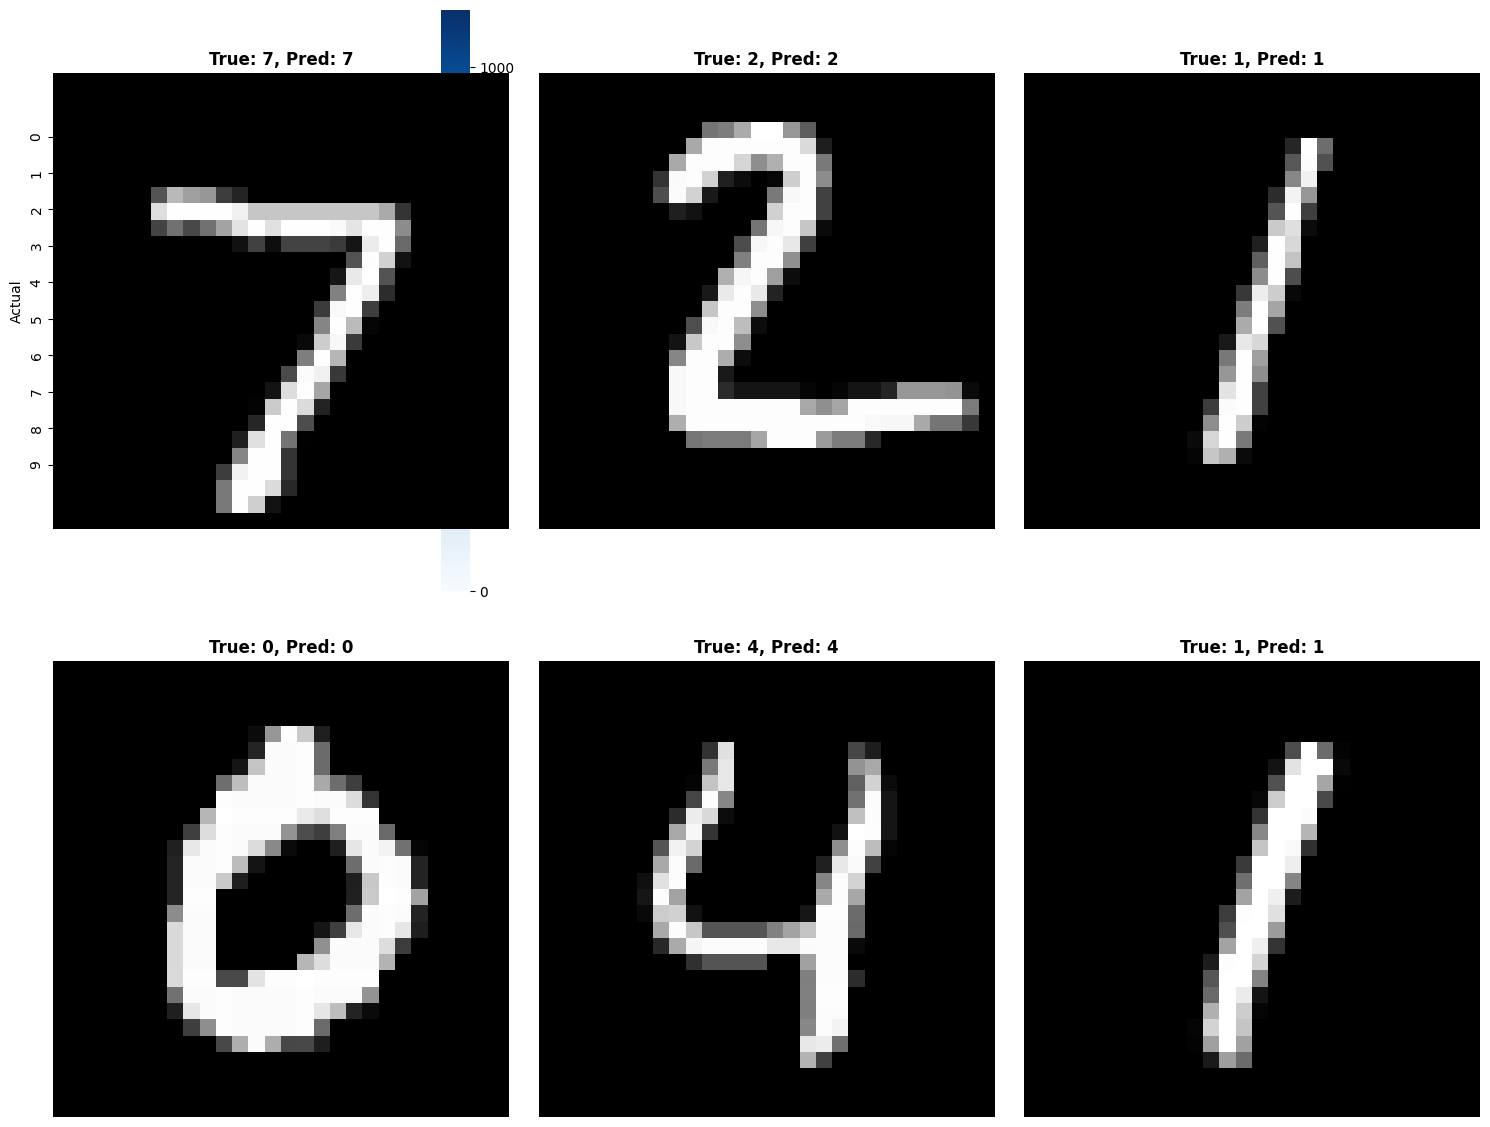

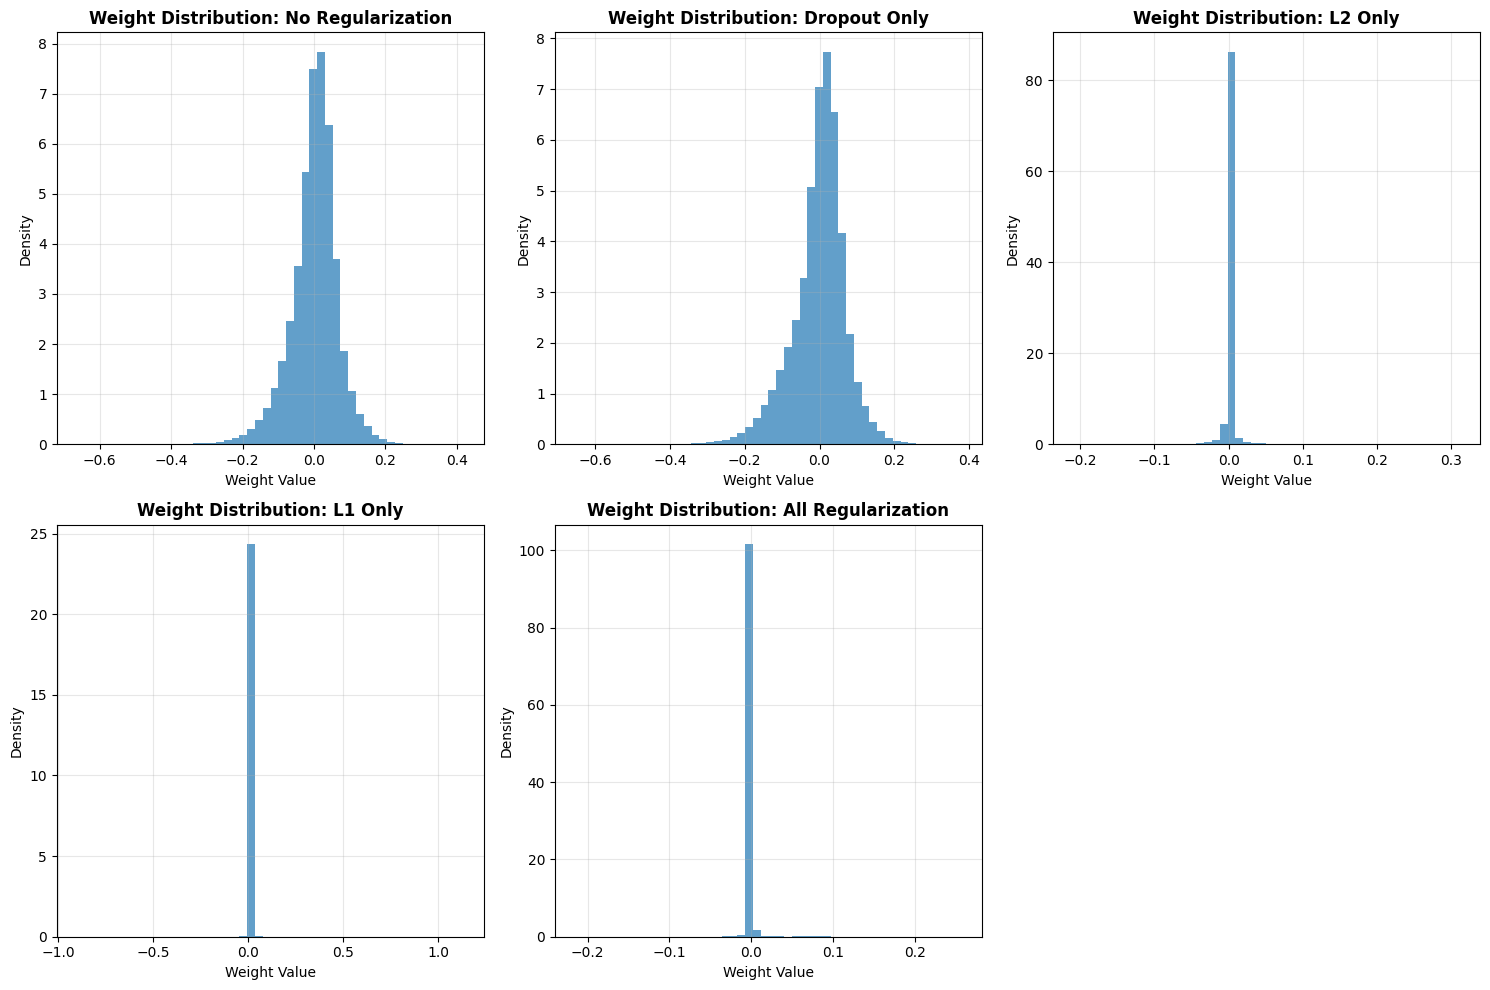

In [12]:
plt.figure(figsize=(15, 12))

plt.subplot(2, 3, 1)
cm = confusion_matrix(true_labels, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True)
plt.title('Confusion Matrix (Best Model)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')

test_images, test_labels = next(iter(test_loader))
test_images, test_labels = test_images.to(device), test_labels.to(device)

with torch.no_grad():
    outputs = best_model(test_images)
    _, predicted = torch.max(outputs, 1)

plt.subplot(2, 3, 2)
for i in range(6):
    plt.subplot(2, 3, i+1)
    img = test_images[i].cpu().squeeze()
    plt.imshow(img, cmap='gray')
    plt.title(f'True: {test_labels[i].item()}, Pred: {predicted[i].item()}',
              fontsize=12, fontweight='bold')
    plt.axis('off')

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))

for i, (name, model) in enumerate(models.items()):
    plt.subplot(2, 3, i+1)
    weights = []
    for param in model.parameters():
        if param.dim() > 1:
            weights.extend(param.cpu().detach().numpy().flatten())

    plt.hist(weights, bins=50, alpha=0.7, density=True)
    plt.title(f'Weight Distribution: {name}', fontsize=12, fontweight='bold')
    plt.xlabel('Weight Value')
    plt.ylabel('Density')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [13]:
regularization_effects = []
for name in models.keys():
    final_train_acc = results[name][2][-1]
    final_test_acc = results[name][3][-1]
    final_train_loss = results[name][0][-1]
    final_test_loss = results[name][1][-1]

    regularization_effects.append({
        'Model': name,
        'Train Accuracy': final_train_acc,
        'Test Accuracy': final_test_acc,
        'Train Loss': final_train_loss,
        'Test Loss': final_test_loss,
        'Overfitting Gap': final_train_acc - final_test_acc
    })

In [ ]:
import pandas as pd
df = pd.DataFrame(regularization_effects)
print("\nRegularization Effects Summary:")
print("="*80)
print(df.to_string(index=False, float_format='%.3f'))

l1_strengths = [0.0, 0.0001, 0.001, 0.01, 0.1]
l1_results = []

for l1_lambda in l1_strengths:
    print(f"\nTesting L1 regularization strength: {l1_lambda}")
    model = RegularizedNet(dropout_rate=0.0).to(device)
    train_losses, test_losses, train_accs, test_accs = train_model(
        model, train_loader, test_loader, epochs=10,
        lr=0.001, l1_lambda=l1_lambda, l2_lambda=0.0
    )
    l1_results.append({
        'L1_Lambda': l1_lambda,
        'Final_Test_Acc': test_accs[-1],
        'Overfitting_Gap': train_accs[-1] - test_accs[-1]
    })



Regularization Effects Summary:
             Model  Train Accuracy  Test Accuracy  Train Loss  Test Loss  Overfitting Gap
 No Regularization          99.597         98.260       0.013      0.083            1.337
      Dropout Only          97.578         98.170       0.085      0.067           -0.592
           L2 Only          96.387         95.870       0.133      0.137            0.517
           L1 Only          95.160         95.450       0.487      0.156           -0.290
All Regularization          83.818         90.040       1.224      0.366           -6.222

Testing L1 regularization strength: 0.0
Epoch [1/10], Train Loss: 0.2543, Test Loss: 0.1187, Train Acc: 92.37%, Test Acc: 96.24%
Epoch [2/10], Train Loss: 0.0948, Test Loss: 0.0839, Train Acc: 97.13%, Test Acc: 97.25%


In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
l1_values = [r['L1_Lambda'] for r in l1_results]
test_accs = [r['Final_Test_Acc'] for r in l1_results]
plt.plot(l1_values, test_accs, 'o-', linewidth=2, markersize=8)
plt.xlabel('L1 Regularization Strength')
plt.ylabel('Test Accuracy (%)')
plt.title('L1 Regularization Effect on Test Accuracy', fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xscale('log')

plt.subplot(1, 2, 2)
overfitting_gaps = [r['Overfitting_Gap'] for r in l1_results]
plt.plot(l1_values, overfitting_gaps, 'o-', color='red', linewidth=2, markersize=8)
plt.xlabel('L1 Regularization Strength')
plt.ylabel('Overfitting Gap (%)')
plt.title('L1 Regularization Effect on Overfitting', fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xscale('log')

plt.tight_layout()
plt.show()